<a href="https://colab.research.google.com/github/AakashAhuja30/Deep-Learning/blob/master/GAN_FakeImageGenerator.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Importing Libraries

In [1]:
from keras.datasets import mnist
import time
import matplotlib.pyplot as plt
import random
import tqdm
import os
import numpy as np
import tensorflow as tf
import tensorflow_datasets as tfds
from tensorflow.keras.layers import LeakyReLU,Dense, Dropout, Input, Reshape, Flatten, Concatenate, BatchNormalization 
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam 

In [2]:
(X_train, y_train), (X_test, y_test) = mnist.load_data()

11493376/11490434 [==============================] - 0s 0us/step


In [3]:
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(60000, 28, 28)
(60000,)
(10000, 28, 28)
(10000,)


In [4]:
%cd /content/drive/MyDrive/

/content/drive/MyDrive


In [5]:
PATH=os.getcwd()

In [6]:
fig,axes=plt.subplots(10,10,figsize=(10,10))
count=0
for i in range(10):
  idx=np.array(np.where(y_train==i))
  idx = np.random.choice(idx[0], 10, replace=False)
  for j in range(10):
    axes[i,j].imshow(X_train[idx[j]])
    axes[i,j].axis('off')


In [7]:
#tf.random.set_seed(1234)

# class_labels
num_classes = 10

#Size of d dim random vector 
d_dim = 100

epochs = 100
batch_size = 128
buffer_size = 60000

row_images_test = 2
col_images_test = 5

# Optimisers
generator_optimizer = tf.keras.optimizers.Adam(1e-4,0.5)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4,0.5)


In [8]:
def scale_images(imgs):
    return 2.*tf.cast(imgs, tf.float32)/255. - 1

#Loading the data    
(mnist_train, label_train), (mnist_test, label_test) = tfds.load('mnist',split=['train', 'test'],batch_size=-1,
                                                                 as_supervised=True)
# Scaling image
mnist_train = scale_images(mnist_train)

#Converting labels to one hot
label_train = tf.one_hot(label_train, depth=10)

# Shuffle and batch
dataset = tf.data.Dataset.from_tensor_slices((mnist_train, label_train)).shuffle(buffer_size).batch(batch_size, drop_remainder=True).prefetch(1)

local data directory. If you'd instead prefer to read directly from our public
GCS bucket (recommended if you're running on GCP), you can instead pass
`try_gcs=True` to `tfds.load` or set `data_dir=gs://tfds-data/datasets`.





Dataset mnist downloaded and prepared to /root/tensorflow_datasets/mnist/3.0.1. Subsequent calls will reuse this data.


#Conditional GAN
1. Generator has to be trained to receive 2 inputs -> random vector and random class labels
2. Random vector is d dimensional vector sampled from std normal distn. D=100
3. here comes the conditional part. You tell the network of your intention. Here we give the network that info through one hot vector of class labels
4. We combine this intention with our random vector. so input to generator is 100+10 dimension
5. Create Architecture for generator 

In [ ]:
#Conditional GAN
#1. Generator has to be trained to receive 2 inputs -> random vector and random class labels
#2. Random vector is d dimensional vector sampled from std normal distn. D=100
#3. here comes the conditional part. You tell the network of your intention. Here we give the network that info through one hot vector of class labels
#4. We combine this intention with our random vector. so input to generator is 100+10 dimension
#5. Create Architecture for generator 

In [9]:
def create_generator():
    
    inputs_rand = Input(shape=(d_dim,))
    inputs_feats = Input(shape=(num_classes,))
    #Combining input of random d dim vector with labels
    inputs = Concatenate()([inputs_rand, inputs_feats])
    
    # add the hidden layers to blow up 110 dim image to 28*28 image
    x = Dense(200, activation='relu')(inputs)
    x = Dense(units=400, activation='relu')(x)
    
    # add the output layer
    x = Dense(units=28*28, activation='tanh')(x)

    output = Reshape((28, 28, 1), input_shape=(28 * 28,))(x)
        
    generator = Model(inputs=[inputs_rand, inputs_feats], outputs=[output, inputs_feats], name='Generator')
    return generator
g=create_generator()
g.summary()

Model: "Generator"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 100)]        0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 10)]         0                                            
__________________________________________________________________________________________________
concatenate (Concatenate)       (None, 110)          0           input_1[0][0]                    
                                                                 input_2[0][0]                    
__________________________________________________________________________________________________
dense (Dense)                   (None, 200)          22200       concatenate[0][0]        

In [10]:
def create_discriminator():
    inputs_img = Input(shape=(28,28,1))
    inputs_feats = Input(shape=(num_classes,))
    x = Flatten()(inputs_img)
    x = Concatenate()([x, inputs_feats])

    # add hidden layers
    x = Dense(units=400, activation='relu')(x)
    x = Dense(units=200, activation='relu')(x)
    x = Dense(units=100, activation='relu')(x)
    
    # add output layer
    output = Dense(units=1, activation='sigmoid')(x)
    
    discriminator = Model(inputs=[inputs_img, inputs_feats], outputs=[output], name='Discriminator')
    return discriminator
d =create_discriminator()
d.summary()

Model: "Discriminator"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 28, 28, 1)]  0                                            
__________________________________________________________________________________________________
flatten (Flatten)               (None, 784)          0           input_3[0][0]                    
__________________________________________________________________________________________________
input_4 (InputLayer)            [(None, 10)]         0                                            
__________________________________________________________________________________________________
concatenate_1 (Concatenate)     (None, 794)          0           flatten[0][0]                    
                                                                 input_4[0][0]        

In [11]:
def create_gan(discriminator, generator):
    gan_input_rand = Input(shape=(100,), name='Random_Input')
    gan_input_feats = Input(shape=(num_classes,), name='Features_Input')
    x = generator([gan_input_rand, gan_input_feats])
    gan_output= discriminator(x)
    gan= Model(inputs=[gan_input_rand, gan_input_feats], outputs=gan_output)
    return gan
gan = create_gan(d,g)
gan.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
Random_Input (InputLayer)       [(None, 100)]        0                                            
__________________________________________________________________________________________________
Features_Input (InputLayer)     [(None, 10)]         0                                            
__________________________________________________________________________________________________
Generator (Functional)          [(None, 28, 28, 1),  416984      Random_Input[0][0]               
                                                                 Features_Input[0][0]             
__________________________________________________________________________________________________
Discriminator (Functional)      (None, 1)            418401      Generator[0][0]              

In [12]:
def plot_generated_images(epoch, generator, noise, feats, 
                          examples=row_images_test*col_images_test, 
                          dim=(row_images_test, col_images_test), 
                          figsize=(8,4)):
    
    generated_images = generator.predict([noise, feats])[0]
    generated_images = generated_images.reshape(examples,28,28)
    plt.figure(figsize=figsize)
    for i in range(generated_images.shape[0]):
        plt.subplot(dim[0], dim[1], i+1)
        plt.imshow(generated_images[i], interpolation='nearest')#, cmap='Greys')
        plt.axis('off')
    plt.tight_layout()
    #plt.savefig(f'images/cgan_{epoch}.png')
    plt.show()

Epoch 1



Epoch 2



Epoch 3



Epoch 4



Epoch 5



Discriminator Loss 0.17489338631972542
Generator Loss 1.3761208159291847


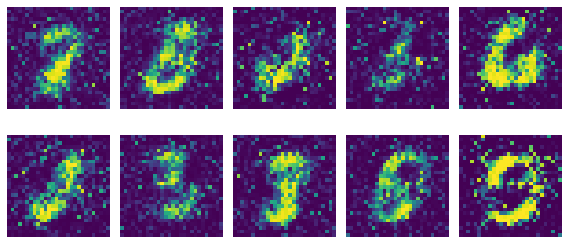

Epoch 6



Epoch 7



Epoch 8



Epoch 9



Epoch 10



Discriminator Loss 0.15211581388631693
Generator Loss 1.5029177540897305


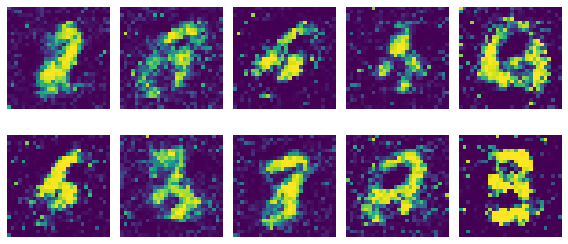

Epoch 11



Epoch 12



Epoch 13



Epoch 14



Epoch 15



Discriminator Loss 0.1492172675844059
Generator Loss 1.5206392522041614


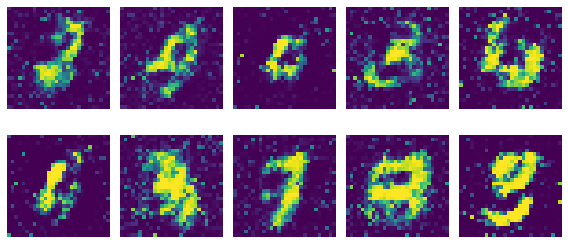

Epoch 16



Epoch 17



Epoch 18



Epoch 19



Epoch 20



Discriminator Loss 0.17059184997700727
Generator Loss 1.3859229790858734


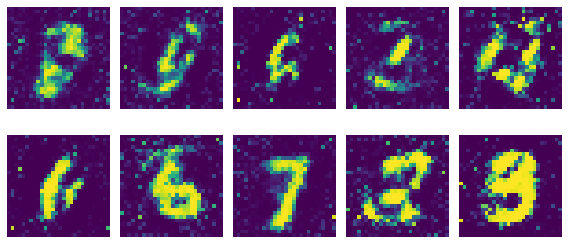

Epoch 21



Epoch 22



Epoch 23



Epoch 24



Epoch 25



Discriminator Loss 0.18692273375952345
Generator Loss 1.2266307279594943


Epoch 26



Epoch 27



Epoch 28



Epoch 29



Epoch 30



Discriminator Loss 0.20561383293670976
Generator Loss 1.1095699313868823


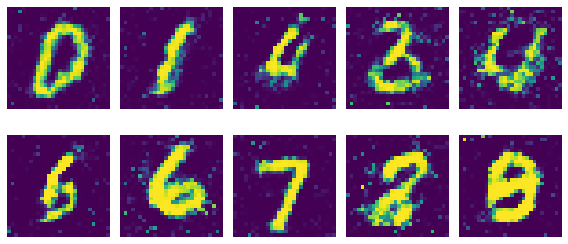

Epoch 31



Epoch 32



Epoch 33



Epoch 34



Epoch 35



Discriminator Loss 0.22498115917874706
Generator Loss 1.0044815955508468


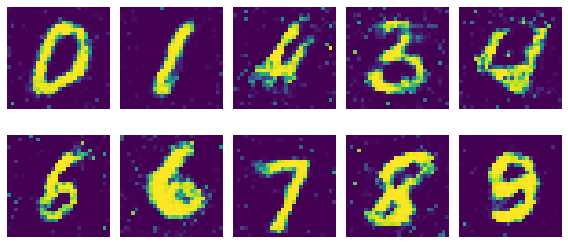

Epoch 36



Epoch 37



Epoch 38



Epoch 39



Epoch 40



Discriminator Loss 0.2339018346566675
Generator Loss 0.9333130652323748


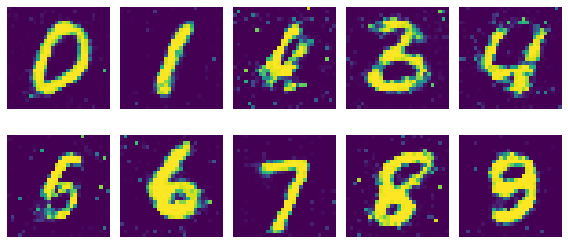

Epoch 41



Epoch 42



Epoch 43



Epoch 44



Epoch 45



Discriminator Loss 0.23924991485272717
Generator Loss 0.8905076626529042


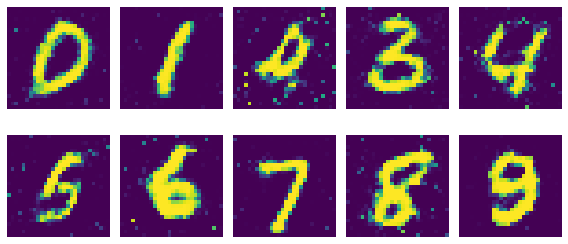

Epoch 46



Epoch 47



Epoch 48



Epoch 49



Epoch 50



Discriminator Loss 0.2417903958668566
Generator Loss 0.8666984291158171


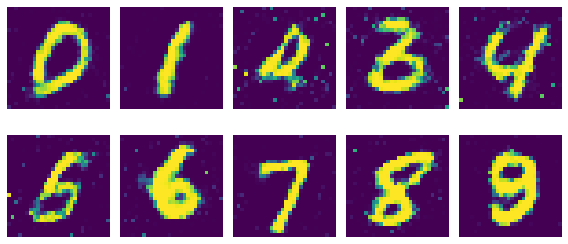

Epoch 51



Epoch 52



Epoch 53



Epoch 54



Epoch 55



Discriminator Loss 0.24359505992924047
Generator Loss 0.8531201309882678


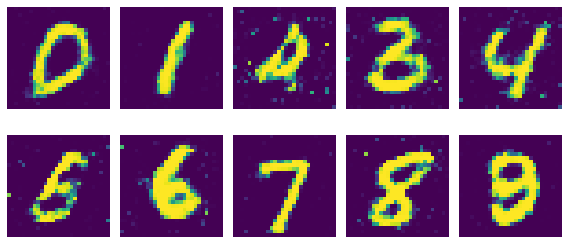

Epoch 56



Epoch 57



Epoch 58



Epoch 59



Epoch 60



Discriminator Loss 0.24409583798394754
Generator Loss 0.8437165065198882


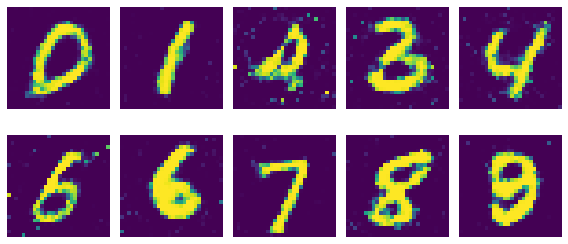

Epoch 61



Epoch 62



Epoch 63



Epoch 64



Epoch 65



Discriminator Loss 0.24378460911540395
Generator Loss 0.8515320243234308


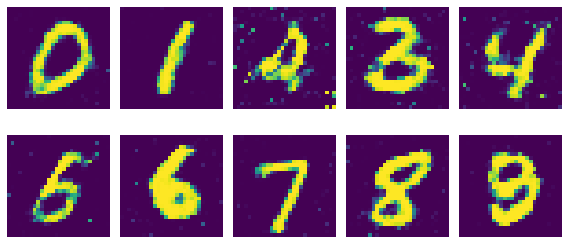

Epoch 66



Epoch 67



Epoch 68



Epoch 69



Epoch 70



Discriminator Loss 0.24374259072236526
Generator Loss 0.8464982743956085


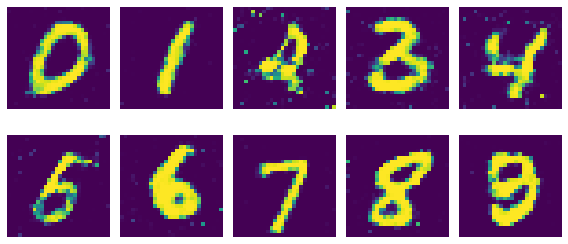

Epoch 71



Epoch 72



Epoch 73



Epoch 74



Epoch 75



Discriminator Loss 0.24397076282682073
Generator Loss 0.8444198534274713


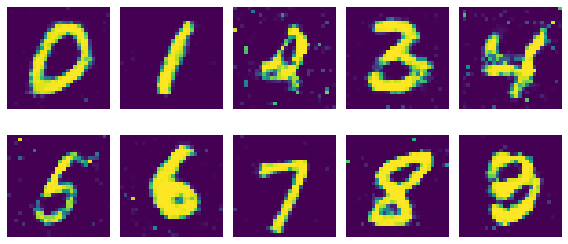

Epoch 76



Epoch 77



Epoch 78



Epoch 79



Epoch 80



Discriminator Loss 0.24370796917977497
Generator Loss 0.8494548954260654


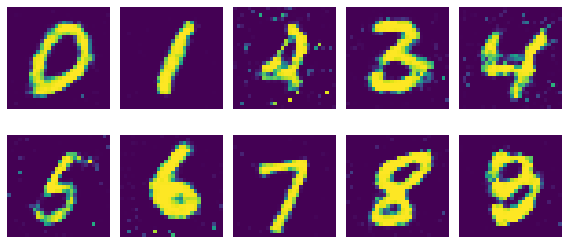

Epoch 81



Epoch 82



Epoch 83



Epoch 84



Epoch 85



Discriminator Loss 0.24276363604471216
Generator Loss 0.8533347217190979


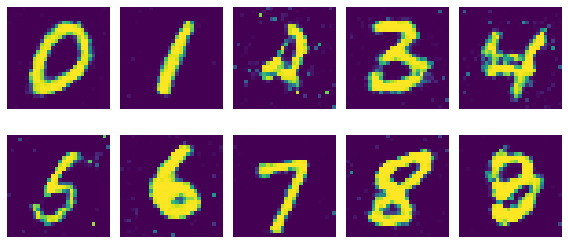

Epoch 86



Epoch 87



Epoch 88



Epoch 89



Epoch 90



Discriminator Loss 0.24270831801506698
Generator Loss 0.8591340238976682


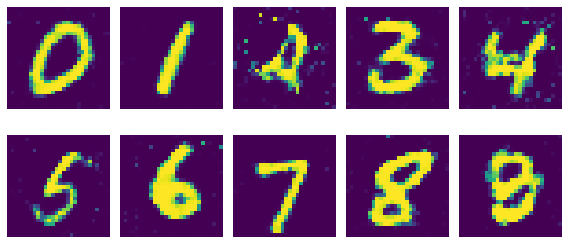

Epoch 91



Epoch 92



Epoch 93



Epoch 94



Epoch 95



Discriminator Loss 0.24112865577141443
Generator Loss 0.8641405891404192


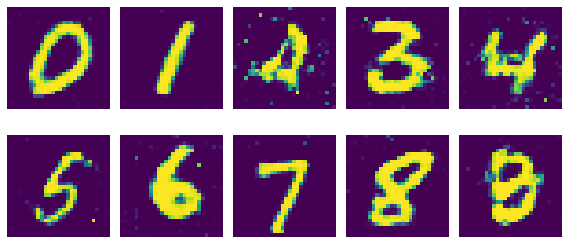

Epoch 96



Epoch 97



Epoch 98



Epoch 99



Epoch 100



Discriminator Loss 0.24130076399216285
Generator Loss 0.8659326916831172


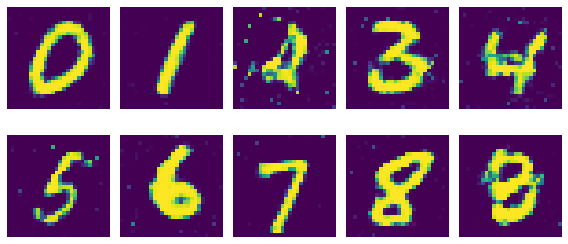

Epoch 101



Epoch 102



Epoch 103



Epoch 104



Epoch 105



Discriminator Loss 0.23942468020842117
Generator Loss 0.8778808406020842


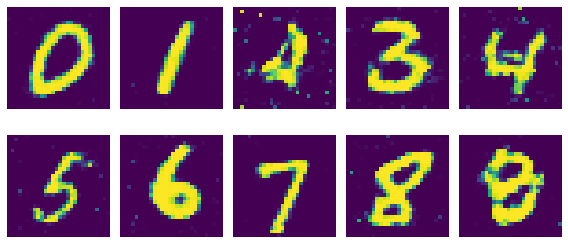

Epoch 106



Epoch 107



Epoch 108



Epoch 109



Epoch 110



Discriminator Loss 0.23841709649970388
Generator Loss 0.8880411380121851


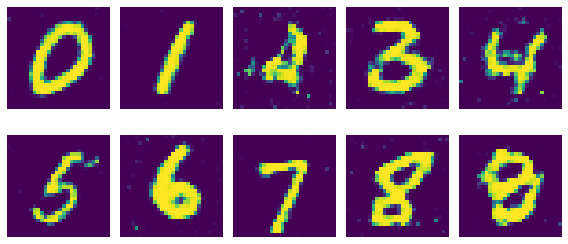

Epoch 111



Epoch 112



Epoch 113



Epoch 114



Epoch 115



Discriminator Loss 0.23867075457277462
Generator Loss 0.8877729693284402


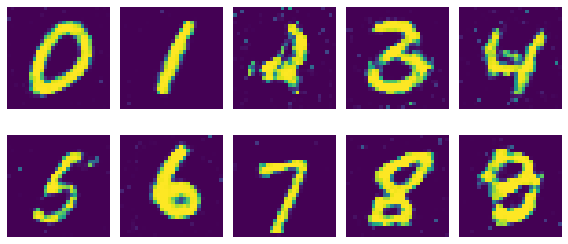

Epoch 116



Epoch 117



Epoch 118



Epoch 119



Epoch 120



Discriminator Loss 0.2365600138775304
Generator Loss 0.8974202131358986


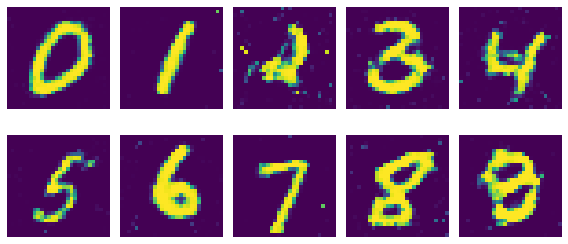

Epoch 121



Epoch 122



Epoch 123



Epoch 124



Epoch 125



Discriminator Loss 0.2359187030352843
Generator Loss 0.9025187077175858


Epoch 126



Epoch 127



Epoch 128



Epoch 129



Epoch 130



Discriminator Loss 0.2333897236161507
Generator Loss 0.9193345955294422


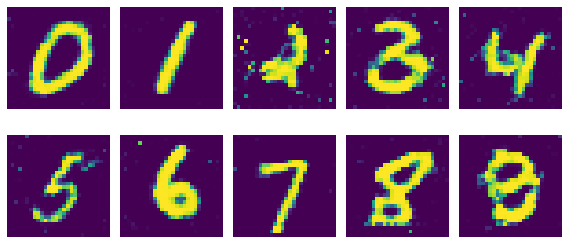

Epoch 131



Epoch 132



Epoch 133



Epoch 134



Epoch 135



Discriminator Loss 0.23292427553007236
Generator Loss 0.9250016239209052


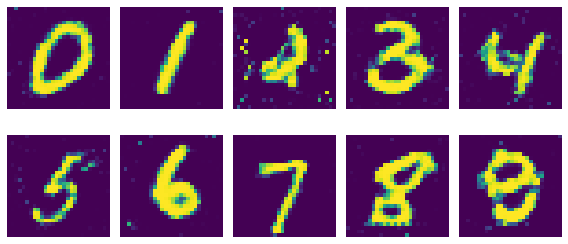

Epoch 136



Epoch 137



Epoch 138



Epoch 139



Epoch 140



Discriminator Loss 0.23235469257347605
Generator Loss 0.9315789904859331


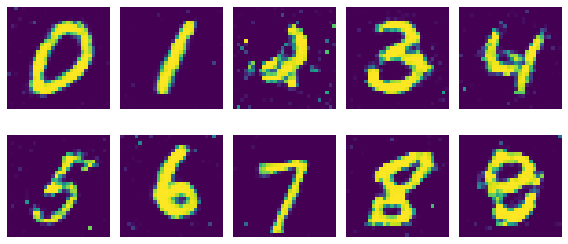

Epoch 141



Epoch 142



Epoch 143



Epoch 144



Epoch 145



Discriminator Loss 0.2305342091772801
Generator Loss 0.9403881102036207


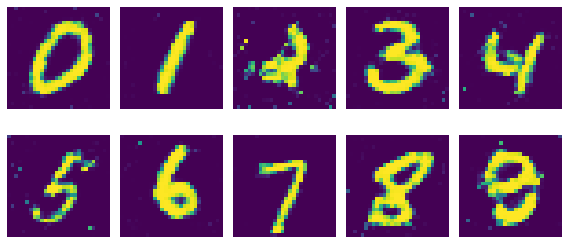

Epoch 146



Epoch 147



Epoch 148



Epoch 149



Epoch 150



Discriminator Loss 0.23075411210839564
Generator Loss 0.9451958725595067


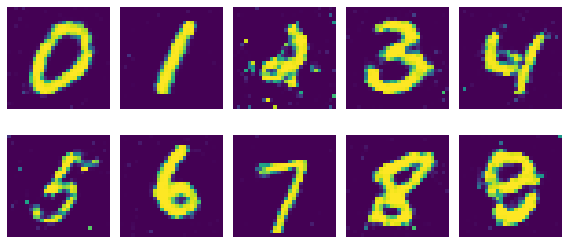

Epoch 151



Epoch 152



Epoch 153



Epoch 154



Epoch 155



Discriminator Loss 0.2296865643439894
Generator Loss 0.955209073347923


Epoch 156



Epoch 157



Epoch 158



Epoch 159



Epoch 160



Discriminator Loss 0.22852829791223392
Generator Loss 0.9632702058451807


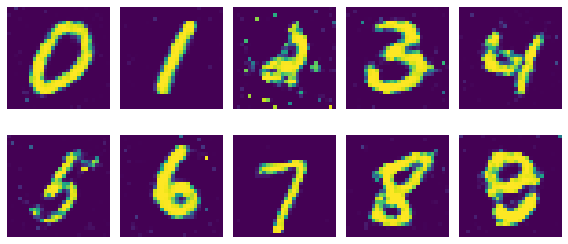

Epoch 161



Epoch 162



Epoch 163



Epoch 164



Epoch 165



Discriminator Loss 0.2271387062680263
Generator Loss 0.9691334618971899


Epoch 166



Epoch 167



Epoch 168



Epoch 169



Epoch 170



Discriminator Loss 0.22811591088708139
Generator Loss 0.9780956665929567


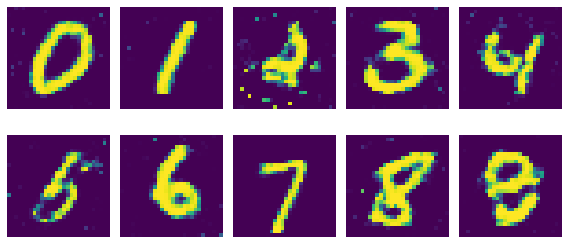

Epoch 171



Epoch 172



Epoch 173



Epoch 174



Epoch 175



Discriminator Loss 0.22591338196817118
Generator Loss 0.9877649177598138


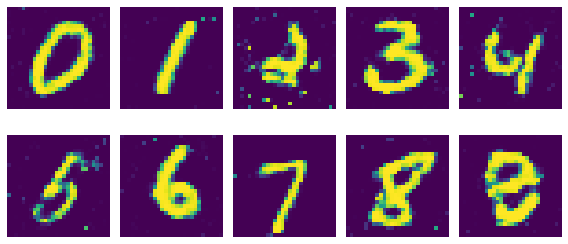

Epoch 176



Epoch 177



Epoch 178



Epoch 179



Epoch 180



Discriminator Loss 0.22484390060297954
Generator Loss 0.9926461224627291


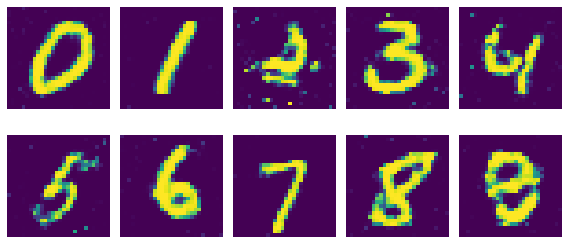

Epoch 181



Epoch 182



Epoch 183



Epoch 184



Epoch 185



Discriminator Loss 0.22484444505256465
Generator Loss 0.9949844377672571


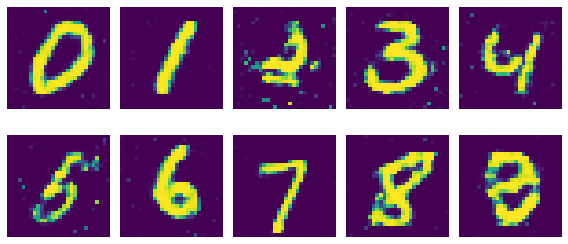

Epoch 186



Epoch 187



Epoch 188



Epoch 189



Epoch 190



Discriminator Loss 0.22463648040325213
Generator Loss 1.004078057841358


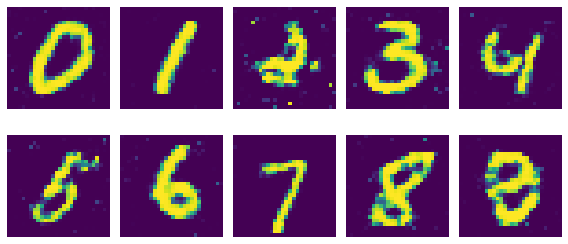

Epoch 191



Epoch 192



Epoch 193



Epoch 194



Epoch 195



Discriminator Loss 0.22378233153150123
Generator Loss 1.0107075284179459


Epoch 196



Epoch 197



Epoch 198



Epoch 199



Epoch 200



Discriminator Loss 0.22236822719056892
Generator Loss 1.0202066113806179


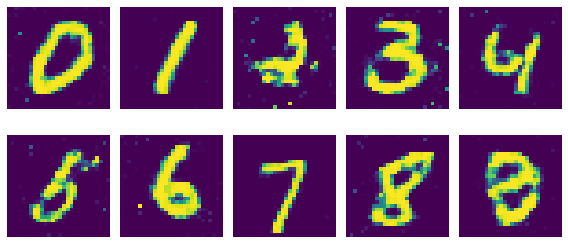

Epoch 201



Epoch 202



Epoch 203



Epoch 204



Epoch 205



Discriminator Loss 0.2217732719822317
Generator Loss 1.0304082602771938


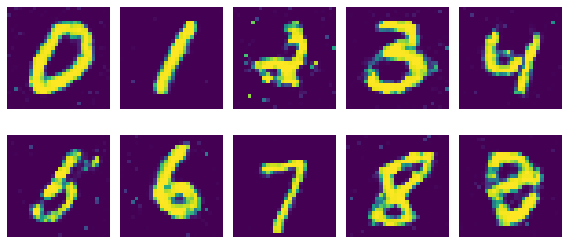

Epoch 206



Epoch 207



Epoch 208



Epoch 209



Epoch 210



Discriminator Loss 0.22197753738643777
Generator Loss 1.031802945666843


Epoch 211



Epoch 212



Epoch 213



Epoch 214



Epoch 215



Discriminator Loss 0.22132075388525796
Generator Loss 1.0388682749536302


Epoch 216



Epoch 217



Epoch 218



Epoch 219



Epoch 220



Discriminator Loss 0.22026709944773942
Generator Loss 1.0482025607528849


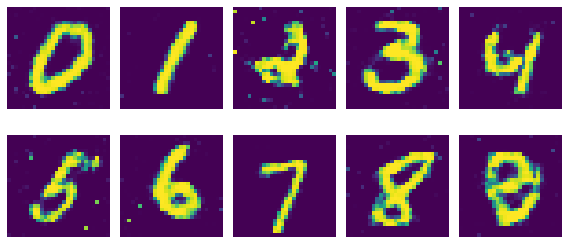

Epoch 221



Epoch 222



Epoch 223



Epoch 224



Epoch 225



Discriminator Loss 0.2200994497945166
Generator Loss 1.0541035532951355


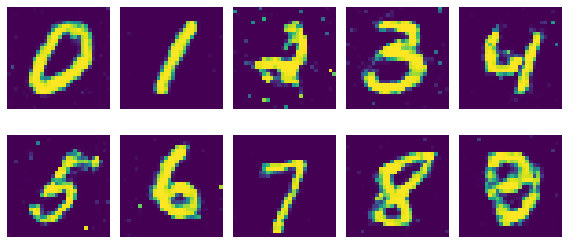

Epoch 226



Epoch 227



Epoch 228



Epoch 229



Epoch 230



Discriminator Loss 0.21976663422189716
Generator Loss 1.061201131878755


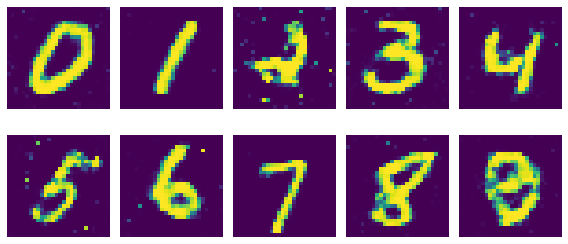

Epoch 231



Epoch 232



Epoch 233



Epoch 234



Epoch 235



Discriminator Loss 0.21864414022455358
Generator Loss 1.071364434229003


Epoch 236



Epoch 237



Epoch 238



Epoch 239



Epoch 240



Discriminator Loss 0.21816526600119904
Generator Loss 1.0690935210794466


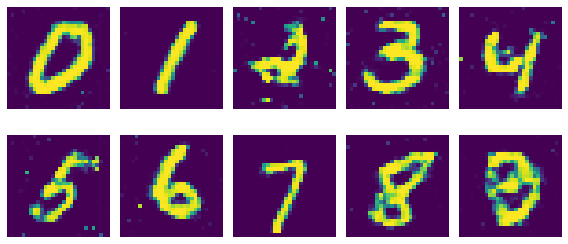

Epoch 241



Epoch 242



Epoch 243



Epoch 244



Epoch 245



Discriminator Loss 0.21677242740033528
Generator Loss 1.0794378484670932


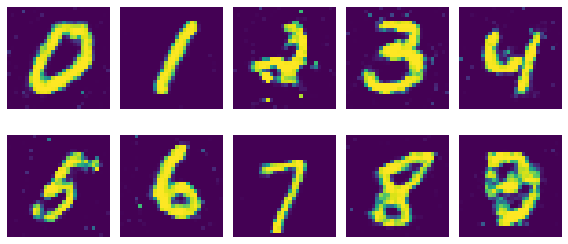

Epoch 246



Epoch 247



Epoch 248



Epoch 249



Epoch 250



Discriminator Loss 0.21538324703454462
Generator Loss 1.0902411848561377


Epoch 251



Epoch 252



Epoch 253



Epoch 254



Epoch 255



Discriminator Loss 0.214582920472464
Generator Loss 1.094432676704521


Epoch 256



Epoch 257



Epoch 258



Epoch 259



Epoch 260



Discriminator Loss 0.21361696164513755
Generator Loss 1.102057424875406


Epoch 261



Epoch 262



Epoch 263



Epoch 264



Epoch 265



Discriminator Loss 0.21400952033507517
Generator Loss 1.1061550392809076


Epoch 266



Epoch 267



Epoch 268



Epoch 269



Epoch 270



Discriminator Loss 0.21310451056840074
Generator Loss 1.114409379979484


Epoch 271



Epoch 272



Epoch 273



Epoch 274



Epoch 275



Discriminator Loss 0.21296180703510076
Generator Loss 1.1207690139611561


Epoch 276



Epoch 277



Epoch 278



Epoch 279



Epoch 280



Discriminator Loss 0.2121057639646734
Generator Loss 1.128223444788884


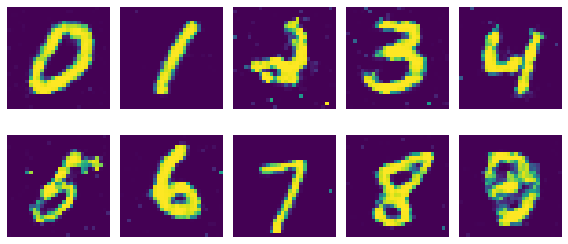

Epoch 281



Epoch 282



Epoch 283



Epoch 284



Epoch 285



Discriminator Loss 0.21179314093011567
Generator Loss 1.1315589643951156


Epoch 286



Epoch 287



Epoch 288



Epoch 289



Epoch 290



Discriminator Loss 0.21132572781708506
Generator Loss 1.1348232342901392


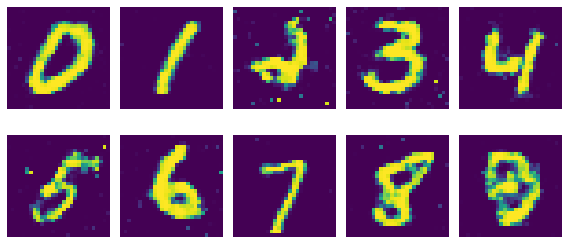

Epoch 291



Epoch 292



Epoch 293



Epoch 294



Epoch 295



Discriminator Loss 0.21067594862582847
Generator Loss 1.1458472882071111


Epoch 296



Epoch 297



Epoch 298



Epoch 299



Epoch 300



Discriminator Loss 0.20854833227001193
Generator Loss 1.1527579785921636


Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.


Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.


Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.


Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.


INFO:tensorflow:Assets written to: /content/drive/MyDrive/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/assets


In [ ]:
def training(EPOCHS):
    discri_loss_act=[]
    discri_loss_fake=[]
    # Creating GAN
    generator= create_generator()
    discriminator= create_discriminator()
    gan = create_gan(discriminator, generator)
    
    discriminator.compile(loss='binary_crossentropy', optimizer=discriminator_optimizer , metrics=['accuracy']
                          )
    discriminator.trainable = False
    gan.compile(loss='binary_crossentropy', optimizer=generator_optimizer ,metrics=['accuracy']
                )
    
    # Use fixed noise to generate example images of d-dimension
    example_noise = tf.random.normal(shape=(row_images_test*col_images_test, d_dim), mean=0, stddev=1)
    example_feats = tf.one_hot(range(10), depth=num_classes)
    
    plot_generated_images(0, generator, example_noise, example_feats)
    
    for e in range(1,EPOCHS+1):
        print(f'Epoch {e}')
        disc_loss_act=[]
        disc_loss_fak=[]
        for batch in tqdm.notebook.tqdm(dataset):
            
            # Generate random noise as an input for the generator.
            noise = tf.random.normal(shape=(batch_size, 100), mean=0, stddev=1)
            feats = tf.one_hot(tf.random.uniform(shape=(batch_size,), minval=0, maxval=9, dtype=tf.int32), depth=num_classes)
            
            # Generate fake images from noise.
            generated_images = generator.predict([noise, feats])
            
            # Construct different batches of  real and fake data.
            #Actual image, labels
            actual_image=batch[0]
            actual_labels=batch[1]
            # Soft labels will improve training.
            y_dis_real = tf.random.uniform(shape = (batch_size,), minval=0.9, maxval=1)
            disc_loss_actual=discriminator.train_on_batch([actual_image, actual_labels], y_dis_real)
            
            #Fake image, labels
            generated_image=generated_images[0]
            generated_labels=generated_images[1]
            y_dis_fake = tf.random.uniform(shape = (batch_size,), minval=0, maxval=0.1)
            disc_loss_fake=discriminator.train_on_batch([generated_image, generated_labels], y_dis_fake)
            
            d_loss = 0.5 * np.add(disc_loss_actual, disc_loss_fake)
                        
            # Now we are going to train the generator to make the discriminator predict incorrectly, that is map the fakes to 1.
            #noise = tf.random.normal(shape = (BATCH_SIZE, 100), mean=0, stddev=1)
            y_gen = tf.random.uniform(shape = (batch_size,), minval=0.9, maxval=1)
                        
            # Then training the GAN with noise as input and targets as real makes the generator try to trick the discriminator.
            # This process of adversarial training will continue until the generator produces good results.
            
            g_loss=gan.train_on_batch([noise, feats], y_gen)
            disc_loss_act.append(d_loss)
            disc_loss_fak.append(g_loss)
        
        
        
        discri_loss_act.append(np.mean(disc_loss_act))
        discri_loss_fake.append(np.mean(disc_loss_fak))
        

        if e % 5 == 0:
          print('Discriminator Loss',np.mean(disc_loss_act))
          print('Generator Loss',np.mean(disc_loss_fak))
          plot_generated_images(e, generator, example_noise, example_feats)
    
    return generator, discriminator,discri_loss_act,discri_loss_fake

g, d,discrim_accuracy_act,generator_accuracy_fake = training(300)

tf.keras.models.save_model(g, PATH)

In [ ]:
fig, ax = plt.subplots(nrows=10, ncols=10, figsize=(10,10))
noises = list()
for col in range(10):
    noise = tf.random.normal(shape=(1, 100), mean=0, stddev=1)
    noises.append(noise)
    for row in range(10):
        feat = np.reshape(tf.one_hot(row, depth=10), (1,10))
        generated_image = g.predict([noise, feat])[0]
        ax[row, col].imshow(np.squeeze(generated_image))
        ax[row, col].axis('off')
        

For Nash Equilibrium we, see that our discriminator loss starts at 0.17 & generator loss starts at 1.37. By the 150th epoch the discriminator loss keeps on increasing & becomes 0.24 as discrminator starts becoming confused as better quality images are created by generator. The generator loss keeps on decreasing as generator keeps on getting better at creating images for any label. So it goes down to close to 0.9. Then the losses kind of become steady with slight increase & decrease for both. 

Question 4: Missing Value Imputation using Conditional GAN

In [ ]:
from keras.datasets import mnist
import time
import matplotlib.pyplot as plt
import random
import tqdm
import os
import numpy as np
import tensorflow as tf
import tensorflow_datasets as tfds
from tensorflow.keras.layers import LeakyReLU,Dense, Dropout, Input, Reshape, Flatten, Concatenate, BatchNormalization
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam 
from keras.models import  Sequential
from tensorflow.keras.layers import Conv2D, Conv2DTranspose
from keras.initializers import  RandomNormal
from keras.layers import  ReLU, LeakyReLU

In [ ]:
batch_size=128
buffer_size=60000
def scale_images(imgs):
    return 2.*tf.cast(imgs, tf.float32)/255. - 1

#Loading the data    
(mnist_train, label_train), (mnist_test, label_test) = tfds.load('mnist',split=['train', 'test'],batch_size=-1,
                                                                 as_supervised=True)
# Scaling image

mnist_train = scale_images(mnist_train)
print(mnist_train.shape)

# Shuffle and batch
dataset = tf.data.Dataset.from_tensor_slices((mnist_train, label_train)).shuffle(buffer_size).batch(batch_size, drop_remainder=True).prefetch(1)
#dataset = tf.data.Dataset.from_tensor_slices((mnist_train, label_train)).shuffle(buffer_size).batch(batch_size, drop_remainder=True).prefetch(1)

# Optimisers
generator_optimizer = tf.keras.optimizers.Adam(1e-4,0.5)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4,0.5)

(60000, 28, 28, 1)


In [ ]:
def create_generator():
    
    #First Input: Random noise of 100 dim
    inputs_rand = Input(shape=(100,))
    
    #2nd input is centre patch of image
    image_input = Input(shape=(10,10,1))

    #Flatten the image_input and concatenate to form 200 dim vector
    x = Flatten()(image_input)
    inputs = Concatenate()([inputs_rand, x])
    
    # add the hidden layers to blow up 110 dim image to 28*28 image
    x = Dense(200, activation='relu')(inputs)
    x = Dense(units=400, activation='relu')(x)
    
    # add the output layer
    x = Dense(units=28*28, activation='tanh')(x)

    output = Reshape((28, 28, 1), input_shape=(28 * 28,))(x)
        
    generator = Model(inputs=[inputs_rand, image_input], outputs=[output], name='Generator')
    generator.compile(optimizer = generator_optimizer,
                loss = ['binary_crossentropy', 'mse'],
                loss_weights = [1,0.1],
                metrics = ['accuracy']
                )
    return generator

generator=create_generator()
generator.summary()

Model: "Generator"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_26 (InputLayer)           [(None, 10, 10, 1)]  0                                            
__________________________________________________________________________________________________
input_25 (InputLayer)           [(None, 100)]        0                                            
__________________________________________________________________________________________________
flatten_16 (Flatten)            (None, 100)          0           input_26[0][0]                   
__________________________________________________________________________________________________
concatenate_8 (Concatenate)     (None, 200)          0           input_25[0][0]                   
                                                                 flatten_16[0][0]         

In [ ]:
def create_discriminator():

    #Discriminator takes as input the output oof generator which is 28*28*1
    inputs_img = Input(shape=(28,28,1))
    x = Flatten()(inputs_img)
    #x = Concatenate()([x, image_input])

    # add hidden layers
    x = Dense(units=400, activation='relu')(x)
    x = Dense(units=200, activation='relu')(x)
    x = Dense(units=100, activation='relu')(x)
    
    # add output layer
    output = Dense(units=1, activation='sigmoid')(x)
    
    discriminator = Model(inputs=[inputs_img], outputs=[output], name='Discriminator')
    discriminator.compile(optimizer = discriminator_optimizer, loss = 'binary_crossentropy',
                          metrics = ['accuracy']#, loss_weights=[0.5]
                          )
 
    return discriminator
discriminator =create_discriminator()
discriminator.summary()

Model: "Discriminator"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_27 (InputLayer)        [(None, 28, 28, 1)]       0         
_________________________________________________________________
flatten_17 (Flatten)         (None, 784)               0         
_________________________________________________________________
dense_59 (Dense)             (None, 400)               314000    
_________________________________________________________________
dense_60 (Dense)             (None, 200)               80200     
_________________________________________________________________
dense_61 (Dense)             (None, 100)               20100     
_________________________________________________________________
dense_62 (Dense)             (None, 1)                 101       
Total params: 414,401
Trainable params: 414,401
Non-trainable params: 0
_______________________________________________

In [ ]:
def create_gan(discriminator, generator):
    #Gan takes input the same generator's input i.e random noise and centre patch of image
    gan_input_rand = Input(shape=(100,), name='Random_Input')
    gan_input_image = Input(shape=(10,10,1), name='Image_Input')
    x = generator([gan_input_rand, gan_input_image])
    gan_output= discriminator(x)
    gan= Model(inputs=[gan_input_rand, gan_input_image], outputs=gan_output)
    return gan
gan = create_gan(discriminator,generator)
gan.summary()

Model: "functional_17"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
Random_Input (InputLayer)       [(None, 100)]        0                                            
__________________________________________________________________________________________________
Image_Input (InputLayer)        [(None, 10, 10, 1)]  0                                            
__________________________________________________________________________________________________
Generator (Functional)          (None, 28, 28, 1)    434984      Random_Input[0][0]               
                                                                 Image_Input[0][0]                
__________________________________________________________________________________________________
Discriminator (Functional)      (None, 1)            414401      Generator[0][0]      

In [ ]:
def train(epochs):

    generator= create_generator()
    discriminator= create_discriminator()
    gan = create_gan(discriminator, generator)
    
    #discriminator.compile(optimizer = Adam(lr=0.0000002, beta_1=0.5), loss = 'binary_crossentropy',
    #                      metrics = ['accuracy']#, loss_weights=[0.5]
    #                      )
    discriminator.trainable = False
    

    gan.compile(loss = ['binary_crossentropy'],
                optimizer=generator_optimizer ,metrics=['accuracy']
                )
    #discriminator.trainable = False
    
    #gan.compile(optimizer = Adam(lr=0.0002, beta_1=0.5),
    #            loss = ['binary_crossentropy'],
                #loss_weights = [1,0.1],
    #            metrics = ['accuracy']
    #            )
    
    real_loss = []
    fake_loss = []
    gan_loss = []
    
    for j in range(1,epochs+1):
      
        for batch in tqdm.notebook.tqdm(dataset):
          

          act_img=batch[0]
          act_labs=batch[1]
            
            # train discriminator with real output images
            
          y_gen = tf.random.uniform(shape = (batch_size,), minval=0.9, maxval=1)
          a = discriminator.train_on_batch([act_img],y_gen)[0]

          real_loss.append(a)  
          #real_loss += a

          generator_inp=act_img[:,9:19,9:19] 
            
            # train discriminator with fake generated images from generator
          input_noise = np.random.normal(0, 1, size=(batch_size, 100))
          gen_outs = generator.predict([input_noise, generator_inp])

          y_dis_fake = tf.random.uniform(shape = (batch_size,), minval=0, maxval=0.1)
          b = discriminator.train_on_batch([gen_outs],y_dis_fake)[0]
          fake_loss.append(b)

 
            # train the gan model
          y_gen = tf.random.uniform(shape = (batch_size,), minval=0.9, maxval=1)
          c = gan.train_on_batch([input_noise, generator_inp],y_gen)[0]
          gan_loss.append(c)
            #print(i, a, b, c)
        print(j, np.mean(fake_loss), np.mean(real_loss), np.mean(gan_loss))

    return generator, discriminator
      
#        print(j, fake_loss/sample_len, real_loss/sample_len, gan_loss/sample_len)

In [ ]:
g_1, d_1 = train(200) 


1 0.5942954533757308 0.37044257883969534 1.1924465200585177



2 0.5730007142146938 0.4176200227891533 1.2750360953629527



3 0.5481377100078468 0.44074575896998414 1.3453464380271754



4 0.5306863349058435 0.454532499345513 1.3913512338494134



5 0.5167052949723016 0.4618212250626495 1.4326177962570108



6 0.5030090336361502 0.46369726217731283 1.4627362122265701



7 0.49078632241640335 0.4639998795339549 1.5063306433268082



8 0.483047492388222 0.46580377355233854 1.5282789797195766



9 0.4771387655949547 0.4672294706566098 1.5460293014080098



10 0.4730414712976696 0.469257850629779 1.5589290177592865



11 0.46942782434457575 0.472055298589581 1.5671042170673724



12 0.46653101710533657 0.4742347445163844 1.573093141277886



13 0.4652134568616013 0.4767801703408821 1.575943850681313



14 0.4641118522446889 0.47904769899107524 1.5789649383652777



15 0.4639136490743724 0.481368015292618 1.5788624328510714



16 0.46421311341592264 0.48338373763383263 1.578483416364552



17 0.4649270701537245 0.48555156526934445 1.5779254103183387



18 0.46565902077107346 0.4876925570435702 1.5768548560745357



19 0.46587202716761217 0.4894228039264974 1.576200253534199



20 0.4661725015626249 0.49092980252149016 1.5760582456540349



21 0.4672564159037138 0.49294709554188465 1.5746770023414165



22 0.46767836058021706 0.4945501999187094 1.574312411688656



23 0.4683503680033606 0.49626963612056274 1.5734982558594277



24 0.4690436478226613 0.4977651796691077 1.5720784354190795



25 0.4697554658391537 0.49923767807264613 1.5709789423810112



26 0.47036380321767124 0.500616686021876 1.570151788395028



27 0.47117698087877924 0.5019943485801244 1.569308769334038



28 0.4716681847610353 0.5029650085636383 1.5689391752657218



29 0.47228522507175735 0.5039997757669136 1.5685168436423467



30 0.47275768496796616 0.5048579731059295 1.5683890259800812



31 0.4731007416858172 0.5057829403122546 1.5676156379506383



32 0.4733962628942652 0.506650830538442 1.5674238368892708



33 0.47362435334119674 0.5072986054244096 1.56767158317569



34 0.47392130556973816 0.5080225459881064 1.5677639157396577



35 0.4741149846923802 0.5087533187089313 1.5681417474197963



36 0.47442789954917836 0.509415442767002 1.5679903795088288



37 0.47457649700255833 0.5099425124498005 1.567889415497013



38 0.474665754999642 0.5105041322741176 1.5680362194059294



39 0.47493548291230603 0.5111135668863194 1.5680325594833748



40 0.47519871975398725 0.5116985431235507 1.5678975885463322



41 0.4754539344545973 0.5122679729540385 1.5677668485407634



42 0.4756152493925443 0.5127581892664725 1.5679226464640819



43 0.47566640622287404 0.5131695972582653 1.5683273865490162



44 0.4757471663013344 0.5135853133738192 1.5689331764715673



45 0.47585505945899886 0.5139575500228749 1.5690611455826564



46 0.4760027246287391 0.5143857393898306 1.5690748070953993



47 0.4761743855166921 0.5148076711303484 1.569046687195899



48 0.47633137393403174 0.515143457238305 1.5692786649108315



49 0.47649228630027657 0.5154271478393191 1.569376180202845



50 0.47658898363383406 0.5156534925988342 1.5696930651455863



51 0.47663371577466856 0.5158408808893238 1.570073938824752



52 0.4766553801402969 0.5159892890214146 1.5704246349583755



53 0.4766678658452674 0.5161755049108276 1.5710851579010632



54 0.47662458276354314 0.5163507471565687 1.5718761102053778



55 0.47664500758480266 0.5165124304279998 1.5725920654051788



56 0.4765995053224202 0.5165952359433076 1.5733771282287998



57 0.47651077690872945 0.516696909919866 1.5741588126475314



58 0.4765059292775373 0.5167803413580775 1.5747058046226863



59 0.4764588544336537 0.5168672988757083 1.5753252061034533



60 0.47640772211734217 0.5169385412782218 1.5760002388255379



61 0.4763536625402772 0.517050361656163 1.5767389278865687



62 0.4763236119542071 0.517116392000499 1.57754897998365



63 0.4763119995458578 0.5172125147126202 1.5784443974547495



64 0.4763288303262467 0.5173216425165987 1.5790238186108092



65 0.4762931323400224 0.51740916501498 1.5795727667194852



66 0.4762535662315757 0.5174763629734478 1.5800919253876005



67 0.4761742078778178 0.5175175635971719 1.580712568185466



68 0.47612550845599133 0.517567650127506 1.5813189221591941



69 0.47606834325241243 0.5175896635401113 1.5820017468360046



70 0.47601959890662093 0.5176066709066012 1.5827425675969276



71 0.4759460971453595 0.5176073412436814 1.5834902757622926



72 0.4758461186802059 0.5175971655004391 1.584288875171729



73 0.47572799556558354 0.5175700385130906 1.5851703844899079



74 0.4756324475875942 0.5175523547407048 1.5860718778713412



75 0.47558011989223314 0.5175560104087038 1.5868570762465142



76 0.47550662691833545 0.5175300745538164 1.587579740249073



77 0.47542241653527756 0.517507054214787 1.5883434846449778



78 0.47537671792668496 0.517491375055934 1.589101853045473



79 0.4753608505398657 0.5174691626362976 1.589909472299334



80 0.4753223500532918 0.5174522795272657 1.590751333291141



81 0.47527023526929635 0.5174469590321509 1.5914613069301922



82 0.47523896229892737 0.5174714420845025 1.5921637014250396



83 0.4752152440581333 0.5174546175820582 1.5928150727299948



84 0.4751744107803801 0.5174332318803251 1.5935012869124472



85 0.475154482278469 0.5174392810612992 1.594093342042257



86 0.47514679380867475 0.5174652369775484 1.594583780422016



87 0.47512999659923666 0.5174907008918854 1.5950651052515425



88 0.4751215891047108 0.5174918016892798 1.5955661164774693



89 0.4751098342958942 0.5174823113109226 1.5960975295626945



90 0.4750802367543563 0.5174720479676045 1.5965992862809757



91 0.47502456185565123 0.5174477015569214 1.5971538221792982



92 0.4749715760639557 0.5174216558396766 1.5977659679904985



93 0.47493320434474845 0.5174079713453654 1.5984159089476295



94 0.47488738262524904 0.5173979901887679 1.5989942331369043



95 0.47484482463099 0.5173722479517563 1.599523942505675



96 0.47478761021551963 0.5173273883992806 1.6001523365903423



97 0.47470625313549525 0.5173120616074937 1.6006895168684834



98 0.47462872096860304 0.5172848658197274 1.601294422744093



99 0.4745498097996262 0.517272564292991 1.6018485602492816



100 0.47445970467522613 0.517249675544345 1.60240772504455



101 0.47435129842999685 0.517198734444741 1.602942607859937



102 0.4742743386764492 0.5171610350549366 1.6035574712377407



103 0.4741880426523537 0.51709109131853 1.60418466676613



104 0.4741118206978726 0.5170162566833414 1.6048996301599332



105 0.4740402448065746 0.5169459446473218 1.6056226846317379



106 0.47397527864439853 0.5168827590510824 1.6063311941629743



107 0.4739081192583415 0.5168112355688123 1.6069482405963764



108 0.4738199441614418 0.5167418373660215 1.6076411072479637



109 0.47372169783070894 0.5166638167217896 1.6083190119003377



110 0.47362863282269996 0.5165901259262268 1.6089509028620097



111 0.4735477941646131 0.5165216340450696 1.6095579195765632



112 0.47347272820122566 0.5164509832410435 1.6101906998401396



113 0.4734124872199788 0.5163879340073428 1.6108512909198598



114 0.4733262068301122 0.5162948506403464 1.6115303696361523



115 0.47324248016578296 0.5162101390904119 1.6122811085393287



116 0.47314953647505614 0.5161239645978276 1.6129732778981534



117 0.47303898421402124 0.5160263028735766 1.6136906445516246



118 0.472947236214723 0.5159275323888102 1.6144382064549816



119 0.4728490136778364 0.5158527740173334 1.6151330884745911



120 0.47276134951480603 0.5157687840545471 1.6158153735706184



121 0.4726757332629981 0.5156807453295471 1.616542470582951



122 0.47257677019811634 0.5155890177798607 1.617220423428747



123 0.4724774161001266 0.5155119068809819 1.617845790743513



124 0.47239133317474413 0.515424394503242 1.6185014536088167



125 0.4722953546607596 0.5153280646161645 1.619202132786441



126 0.47220348935458556 0.5152419850807887 1.6198547676047952



127 0.47209941648742587 0.5151665460111993 1.620461066368371



128 0.4719976119679184 0.5150771769861647 1.621081834837086



129 0.4719026724534007 0.5149875571561908 1.6216335963219146



130 0.47178753256004236 0.5148861168460636 1.6222283350126199



131 0.47167187664030025 0.5147916108995448 1.6228971188812484



132 0.47156239870228445 0.5146936472142064 1.6235908698691



133 0.4714523401006268 0.5145935468561457 1.6242931592800371



134 0.47133271047154746 0.5144803221391554 1.6250452777941793



135 0.47122458759866287 0.5143815126709921 1.6257387969691228



136 0.47112024284650134 0.5142751480396528 1.62643098852622



137 0.4710080932215264 0.5141679505991957 1.6271573948801787



138 0.4709280618407256 0.5140656806912957 1.6278762992171052



139 0.47083721949267576 0.5139677693064855 1.6286041415535581



140 0.4707325356151631 0.5138663403633004 1.6293180333634654



141 0.47062517378623536 0.5137583217650494 1.630074032972045



142 0.47053857988854947 0.5136450363151112 1.6307969336320924



143 0.47043894154814153 0.5135054951212491 1.6315887545167378



144 0.4703432042598335 0.5133848022371053 1.6323610234497945



145 0.4702318220531347 0.5132639299831119 1.633123864704727



146 0.4701296221528116 0.5131604510967154 1.633906633535023



147 0.47001970424200673 0.5130500260105233 1.634692270827055



148 0.4698971794441869 0.5129298961007756 1.6355016168984



149 0.46979800271878847 0.5128169921091906 1.6362472876888445



150 0.46968352847416855 0.5126995834391935 1.6370112773028873



151 0.46956691509717363 0.5125744556881103 1.6378520997355532



152 0.469456812946249 0.512463254793126 1.6386686903116634



153 0.46933908344254094 0.512341445084549 1.6394752868002243



154 0.4692228347731293 0.5122099998508892 1.640317725708018



155 0.4691152595593675 0.5120769537808664 1.6411481927298697



156 0.46901166529596544 0.5119409698447196 1.6419258625312918



157 0.4688962948712327 0.5118074701624711 1.6427953555661636



158 0.46878296769667754 0.5116755254399408 1.6436648393880298



159 0.4686662340282894 0.5115390845277514 1.6445438151921097



160 0.46856464696411265 0.5114068620378533 1.6453971292847434



161 0.4684445456397339 0.5112725323871116 1.6462734516674644



162 0.4683221880194412 0.5111349460627489 1.647197797140536



163 0.4682117054703527 0.5110131562606636 1.6480951891740976



164 0.4680922473261468 0.510884128996125 1.6489907146790872



165 0.46798647947260147 0.510756679981314 1.64987927203242



166 0.46786516077142093 0.5106170419131739 1.6507594047106389



167 0.4677599993946639 0.5104800142287564 1.6516437054609312



168 0.4676483226318396 0.510353146211309 1.652527640195769



169 0.46754691246398655 0.5102270498379318 1.653378261786512



170 0.46744076564023995 0.5100928641351894 1.6542620050608963



171 0.4673470148814191 0.5099590348658228 1.655124870686271



172 0.4672453986401972 0.5098230602338916 1.6559578120712908



173 0.46713689894042143 0.5096873786928204 1.656844661836803



174 0.4670166507874225 0.5095460167450563 1.6577506456328335



175 0.46689583677948615 0.5094062027369736 1.6586620773493297



176 0.4667757047270081 0.5092667610373307 1.6596002764717648



177 0.46664839315747725 0.5091283726704936 1.6605385522034726



178 0.4665335869663623 0.5089985893304626 1.6614375903352439



179 0.4664102774799135 0.5088651395059857 1.6623223555010915



180 0.4662875295796229 0.5087280219873628 1.6632025382167537



181 0.4661496857282077 0.5085778491547885 1.6641312549801495



182 0.46601921662085044 0.5084403725095163 1.6650529439029498



183 0.4658925696075823 0.5082980172274439 1.6659478505206105



184 0.46576069907185946 0.5081512835587987 1.666890121851738



185 0.4656155488254375 0.5079959474294021 1.6678756990652213



186 0.46546608317660865 0.5078328566625886 1.668912768419416



187 0.4653316394435847 0.5076793920477076 1.66990474497884



188 0.46518854221868006 0.5075276779115219 1.6709050007793151



189 0.4650524887109969 0.50738379168289 1.6718753405824713



190 0.46492728496618063 0.507244558427089 1.6728406799487097



191 0.464802908145307 0.5071035190520217 1.6737678668812606



192 0.4646744898940301 0.5069534066297376 1.6747203864498155



193 0.46456945368867586 0.5068131698047434 1.6756696199494179



194 0.4644646868979561 0.506674909726552 1.6765838287707069



195 0.46435331156183013 0.5065359774747556 1.6775156029105944



196 0.4642383100972757 0.5063910892456783 1.6784252688950183



197 0.46410433736246853 0.5062419610279266 1.6793528784542746



198 0.46397486279228034 0.5060986937451852 1.6803081035723364



199 0.463862625321948 0.5059561798472944 1.6812548899938062



200 0.46374491176926175 0.5058173726051728 1.682204960426077


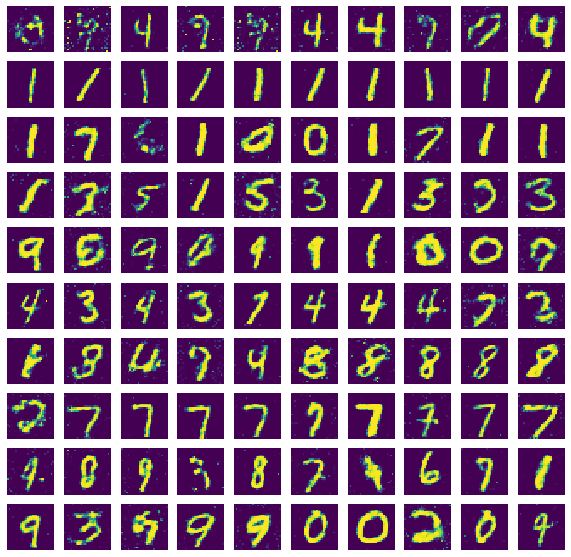

In [ ]:
fig, ax = plt.subplots(nrows=10, ncols=10, figsize=(10,10))
noises = list()
for col in range(10):
  noise = tf.random.normal(shape=(1,100), mean=0, stddev=1)
  for row in range(10):
    idx=np.array(np.where(label_train==row))
    idx = np.random.choice(idx[0], 10, replace=False)
    dat = mnist_train[idx[0]]
    feat=dat[9:19,9:19,:] 
    feat = feat[tf.newaxis,:,:]
    generated_image = g_1.predict([noise, feat])
    ax[row, col].imshow(np.squeeze(generated_image), interpolation='nearest')
    ax[row, col].axis('off')
        

Digits 1 & 7 are classified perfectly by the generator. 3,8 & 9 are also not bad. For 6, the confusion between 6, 8 is justified. 